In [1]:
# Import the Required Packages
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import csv
import os

## Step 1: Data Loading

In [2]:
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
validation_dir = os.path.join(os.getcwd(), 'validation')

### Mobilenet PRETRAIN MODEL Base

In [3]:
img_size = 224

mobilenet_base = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                             include_top=False,
                                                             input_shape=(img_size, img_size, 3))

In [4]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Feature Extraction with Basic Data augmentation With MobileNet

In [5]:
# features shape need to follow model last layer
# Need to add a comma and 10 for labels shape as there are 10 classes for the dataset

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1280))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = mobilenet_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 7500)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 500)

Found 7500 images belonging to 10 classes.
1/1 [==============================] - 1s 561ms/step
Found 2000 images belonging to 10 classes.
1/1 [==============================] - 0s 34ms/step
Found 500 images belonging to 10 classes.
1/1 [==============================] - 0s 37ms/step


In [7]:
print(train_features.shape)
print(train_labels.shape)

(7500, 7, 7, 1280)
(7500, 10)


In [9]:
train_features = np.reshape(train_features, (7500, 7 * 7 * 1280))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 1280))
test_features = np.reshape(test_features, (500, 7 * 7 * 1280))

### Build the Model

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

mobilenet_base.trainable = False

mobilenet_2 = models.Sequential()
mobilenet_2.add(mobilenet_base)
mobilenet_2.add(layers.Flatten())
mobilenet_2.add(layers.Dense(256, activation='relu'))
mobilenet_2.add(layers.Dense(10, activation='softmax'))

In [11]:
mobilenet_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 18,317,130
Trainable params: 16,059,146
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
mobilenet_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), # set learning rate to adam & lr of 0.001
              metrics=['acc'])

In [13]:
# Testing basic augmentations

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')


Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [14]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'mobilenet_augmentation_basic.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

history = mobilenet_2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[mc]
)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 3.0695 - acc: 0.5824
Epoch 1: val_loss improved from inf to 1.01100, saving model to mobilenet_augmentation_basic.keras
235/235 [==============================] - 94s 393ms/step - loss: 3.0695 - acc: 0.5824 - val_loss: 1.0110 - val_acc: 0.7250
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.8845 - acc: 0.7181
Epoch 2: val_loss improved from 1.01100 to 0.82662, saving model to mobilenet_augmentation_basic.keras
235/235 [==============================] - 87s 368ms/step - loss: 0.8845 - acc: 0.7181 - val_loss: 0.8266 - val_acc: 0.7485
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.7914 - acc: 0.7509
Epoch 3: val_loss improved from 0.82662 to 0.78988, saving model to mobilenet_augmentation_basic.keras
235/235 [==============================] - 90s 383ms/step - loss: 0.7914 - acc: 0.7509 - val_loss: 0.7899 - val_acc: 0.7685
Epoch 4/30
235/235 [==============================

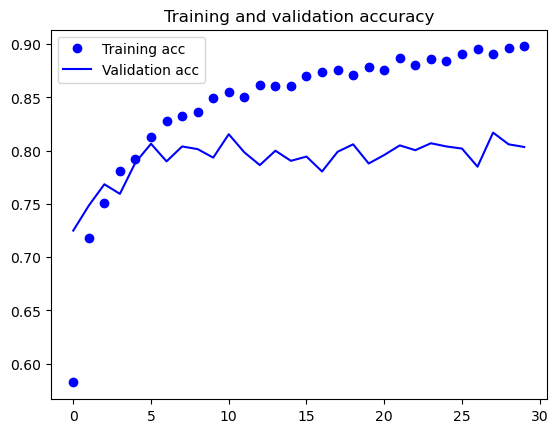

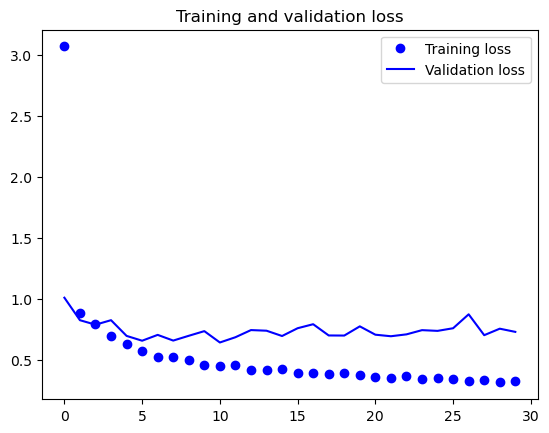

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### More data augmentations by including colour and lighting

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

mobilenet_base.trainable = False

mobilenet_3 = models.Sequential()
mobilenet_3.add(mobilenet_base)
mobilenet_3.add(layers.Flatten())
mobilenet_3.add(layers.Dense(256, activation='relu'))
mobilenet_3.add(layers.Dense(10, activation='softmax'))

In [6]:
mobilenet_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 18,317,130
Trainable params: 16,059,146
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
mobilenet_3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), # set learning rate to adam & lr of 0.001
              metrics=['acc'])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20,
    featurewise_center=False,
    featurewise_std_normalization=False, 
    preprocessing_function=None
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')


validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [9]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'mobilenet_augmentation_advanced.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

history = mobilenet_3.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[mc]
)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 2.7319 - acc: 0.5816
Epoch 1: val_loss improved from inf to 0.94444, saving model to mobilenet_augmentation_1.keras
235/235 [==============================] - 98s 398ms/step - loss: 2.7319 - acc: 0.5816 - val_loss: 0.9444 - val_acc: 0.7070
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.9289 - acc: 0.7085
Epoch 2: val_loss improved from 0.94444 to 0.87994, saving model to mobilenet_augmentation_1.keras
235/235 [==============================] - 91s 387ms/step - loss: 0.9289 - acc: 0.7085 - val_loss: 0.8799 - val_acc: 0.7500
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.8138 - acc: 0.7436
Epoch 3: val_loss improved from 0.87994 to 0.79612, saving model to mobilenet_augmentation_1.keras
235/235 [==============================] - 91s 387ms/step - loss: 0.8138 - acc: 0.7436 - val_loss: 0.7961 - val_acc: 0.7610
Epoch 4/30
235/235 [==============================] - ETA: 0s 

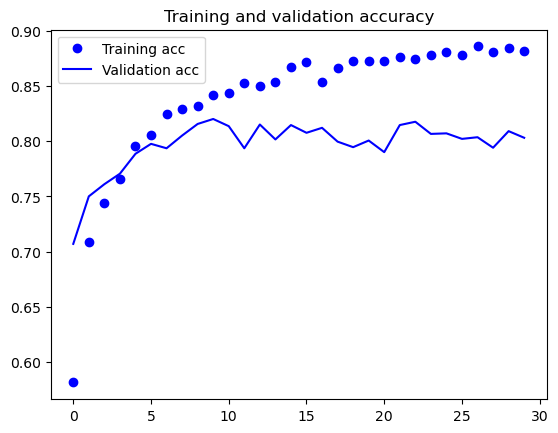

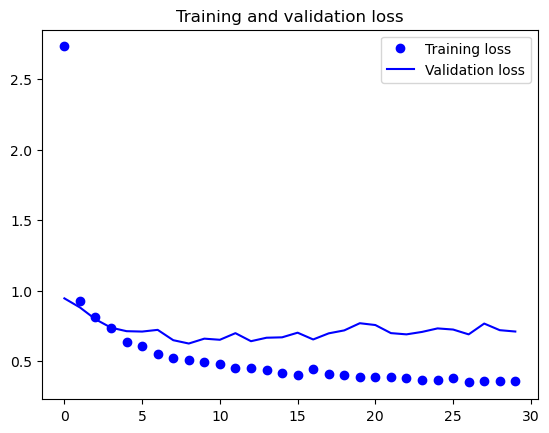

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()